# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [46]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [47]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [48]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-17 09:00:00+09:00,47820.968750,47926.250000,47750.558594,47781.378906,0,0.0,0.0
2025-10-17 09:15:00+09:00,47780.980469,47827.890625,47734.761719,47776.781250,0,0.0,0.0
2025-10-17 09:30:00+09:00,47771.320312,47828.230469,47729.859375,47807.460938,0,0.0,0.0
2025-10-17 09:45:00+09:00,47819.210938,47905.500000,47729.109375,47867.238281,0,0.0,0.0
2025-10-17 10:00:00+09:00,47869.570312,47947.820312,47869.570312,47947.820312,0,0.0,0.0


## 前日終値の取得

In [49]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-10 00:00:00+09:00    48088.800781
2025-10-14 00:00:00+09:00    46847.320312
2025-10-15 00:00:00+09:00    47672.671875
2025-10-16 00:00:00+09:00    48277.738281
2025-10-17 00:00:00+09:00    47947.820312
Name: Close, dtype: float64


Date
2025-10-16 00:00:00+09:00    48277.738281
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [50]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-456.77


## ローソク足チャート（小さいサイズ）

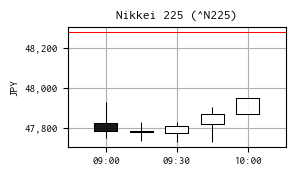

In [51]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [52]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [53]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-16 08:00:00+09:00,150.906998,150.988007,150.876999,150.970001,0,0.0,0.0
2025-10-16 08:15:00+09:00,150.966003,151.037994,150.938995,151.003998,0,0.0,0.0
2025-10-16 08:30:00+09:00,151.005997,151.022995,150.923004,150.970993,0,0.0,0.0
2025-10-16 08:45:00+09:00,150.968994,151.003998,150.904007,150.983002,0,0.0,0.0
2025-10-16 09:00:00+09:00,150.983002,151.091003,150.774994,150.787003,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-17 09:15:00+09:00,150.126007,150.212997,150.039993,150.147003,0,0.0,0.0
2025-10-17 09:30:00+09:00,150.145996,150.199005,150.100998,150.190002,0,0.0,0.0
2025-10-17 09:45:00+09:00,150.184998,150.231003,150.037003,150.229004,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [54]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-17 09:00:00+09:00,318.551627,319.252941,318.082602,318.287906
2025-10-17 09:15:00+09:00,318.228000,318.540428,317.920176,318.200032
2025-10-17 09:30:00+09:00,318.072572,318.451493,317.796515,318.313204
2025-10-17 09:45:00+09:00,318.308780,318.883163,317.709018,318.628474
2025-10-17 10:00:00+09:00,318.622800,319.143637,318.622800,319.143637


### 前日の終値のドル円レートから、前日の終値のドル換算

In [55]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-16 15:15:00+09:00


np.float64(151.07200622558594)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 319.5677312258633


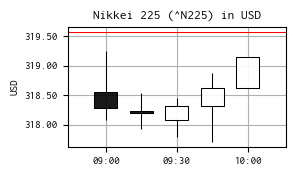

In [56]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()